In [1]:
import datetime
from datetime import datetime
from datetime import timedelta
from os import X_OK
from keras.utils.generic_utils import default
from konlpy.tag import Kkma
import json
from collections import Counter
import time
import re
from tqdm import tqdm 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import math
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.layers import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr 
import matplotlib.pyplot as plt 

# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#cross_validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import datasets
from sklearn import metrics

import datetime
from datetime import datetime

import torch 
import torch.nn as nn 
from torch.autograd import Variable 

import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as Func

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mm = MinMaxScaler()
ss = StandardScaler()

class Extra_f:
    def __init__(self, df):
        self.df = df
        self.day_list = [3, 7, 15, 30]

        self.ma()
        self.ema()
        self.ppo()
        self.rsi()
        self.high_low()
        self.cci()
        self.macd()
        
    #이동평균선
    def ma(self):
        for day in self.day_list:
            #이동평균 칼럼 추가 당일 포함 3일 7일 15일 30일
            self.df['MA_{}'.format(int(day))] = self.df['close'].rolling(window=int(day)).mean()
            
    #지수이동평균선
    def ema(self):
        for day in self.day_list:
            self.df['EWM_{}'.format(int(day))] = self.df['close'].ewm(span=int(day)).mean()

    #이격도
    def ppo(self):
        for day in self.day_list:
            self.df['PPO_{}'.format(int(day))] = (self.df['close'] / self.df['MA_{}'.format(int(day))])*100
            
    #rsi        
    def rsi(self):
        def U(x):
            if x >= 0:
                return x
            else :
                return 0
        def D(x):
            if x <= 0:
                return x*(-1)
            else :
                return 0
            
        self.df['diff_rsi'] = (self.df['close'].shift(1) - self.df['close'])
        self.df['AU'] = self.df['diff_rsi'].apply(U).rolling(window=14).mean() 
        self.df['AD'] = self.df['diff_rsi'].apply(D).rolling(window=14).mean() 
        self.df['RSI'] = self.df['AU']/(self.df['AU']+self.df['AD'])
        self.df.drop(['diff_rsi', 'AU', 'AD'], axis=1, inplace = True)
        
    #모멘텀 스토캐스틱
    def high_low(self):
        day = 5
        self.df['high_st'] = np.nan
        self.df['low_st'] = np.nan
        self.df = self.df.reset_index()
        
        for i in range(len(self.df)-day+1):
            self.df.loc[i, 'high_st']= self.df[i:i+day]['high'].max()
            self.df.loc[i, 'low_st']= self.df[i:i+day]['low'].min()

        self.df['high_st_4'] = self.df['high_st'].shift(4)
        self.df['low_st_4'] = self.df['low_st'].shift(4)

        self.df['fast_K'] = (self.df['close']-self.df['low_st_4'])/(self.df['high_st_4']-self.df['low_st_4'])
        self.df['fast_D'] = self.df['fast_K'].rolling(3).mean()
        self.df['slow_K'] = self.df['fast_D']
        self.df['slow_D'] = self.df['slow_K'].rolling(3).mean()
        self.df = self.df.set_index('date')
        
        self.df = self.df.drop(['high_st', 'low_st', 'high_st_4', 'low_st_4', 'fast_K', 'fast_D'], axis = 1)
    
    #CCI
    def cci(self):
        #CCI = (M-N) / (0.015*D)
        # M=특정일의 고가,저가, 종가의 평균
        # N = 일정기간동안의 단순이동평균 통상적으로 20일로 사용
        # D = M-N의 일정기간동안의 단순이동평균
        M = ((self.df.high)+(self.df.low)+(self.df.close)) / 3
        N = M.rolling(20).mean()
        D = (M-N).rolling(20).mean()
        CCI = (M - N)/ (0.015 * D)
        self.df['CCI'] = CCI
        
    #macd
    def macd(self):
        short_ = 12 
        long_ = 26 
        t = 9 

        ma_12 = self.df.close.ewm(span = short_).mean()
        ma_26 = self.df.close.ewm(span = long_).mean() # 장기(26) EMA
        macd = ma_12 - ma_26 # MACD
        macdSignal = macd.ewm(span = t).mean() # Signal
        macdOscillator = macd - macdSignal # Oscillator
        self.df['macd'] = macdOscillator
        
    def show_df(self):
        print(self.df)
        
    def return_df(self):
        return(self.df)

class Scaler:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.prob = 0.7
        
    def prep(self):
        
        self.X_ss = ss.fit_transform(self.X)
        self.y_mm = mm.fit_transform(self.y)
        
        #------Test Data------------------------------------------------
        self.X_train = self.X_ss[:int(len(self.X_ss) * self.prob), :]
        self.X_test = self.X_ss[int(len(self.X_ss) * self.prob):, :]
        self.y_train = self.y_mm[:int(len(self.y_mm) * self.prob), :]
        self.y_test = self.y_mm[int(len(self.y_mm) * self.prob):, :]
        #---------------------------------------------------------------
        
        #numpy형태에서는 학습이 불가능하기 때문에 학습할 수 있는 형태로 변환하기 위해 Torch로 변환

        self.X_train_tensors = Variable(torch.Tensor(self.X_train)) 
        self.X_test_tensors = Variable(torch.Tensor(self.X_test)) 

        self.y_train_tensors = Variable(torch.Tensor(self.y_train)) 
        self.y_test_tensors = Variable(torch.Tensor(self.y_test)) 

        self.X_train_tensors_final = torch.reshape(self.X_train_tensors, 
                                                   (self.X_train_tensors.shape[0], 1, self.X_train_tensors.shape[1])) 
        self.X_test_tensors_final = torch.reshape(self.X_test_tensors, 
                                                  (self.X_test_tensors.shape[0], 1, self.X_test_tensors.shape[1]))
        
        return self.X_train_tensors_final, self.X_test_tensors_final, self.y_train_tensors, self.y_test_tensors, int(len(self.X_ss) * self.prob)

#--------------< LSTM Model >---------------------------------------------      
class LSTM1(nn.Module): 
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): 
    super(LSTM1, self).__init__() 
    self.num_classes = num_classes #number of classes 
    self.num_layers = num_layers #number of layers 
    self.input_size = input_size #input size 
    self.hidden_size = hidden_size #hidden state 
    self.seq_length = seq_length #sequence length 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm 
    self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1 
    self.fc = nn.Linear(128, num_classes) #fully connected last layer 

    self.relu = nn.ReLU() 
    
  def forward(self,x): 
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state 
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state 
    # Propagate input through LSTM 
    
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state 
    
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next 
    out = self.relu(hn) 
    out = self.fc_1(out) #first Dense 
    out = self.relu(out) #relu 
    out = self.fc(out) #Final Output 
    
    return out

class LSTM_predict:
    def __init__(self, lstm1, num_epochs, learning_rate, X_train, y_train, length, df):
        self.lstm1 = lstm1
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.X_train = X_train
        self.y_train = y_train
        self.length = length
        self.df = df
        
        self.epochs()
        self.predict()
    
    def epochs(self):
        loss_function = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(self.lstm1.parameters(), lr=self.learning_rate)  # adam optimizer

        for epoch in range(self.num_epochs): 
          outputs = self.lstm1.forward(self.X_train.to(device)) #forward pass 
          optimizer.zero_grad() #caluclate the gradient, manually setting to 0 

          # obtain the loss function 
          loss = loss_function(outputs, self.y_train.to(device)) 

          loss.backward() #calculates the loss of the loss function 

          optimizer.step() #improve from loss, i.e backprop 
          if epoch % 100 == 0: 
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
    def predict(self):
        df_X_ss = ss.transform(self.df.drop(columns='close').iloc[:-1])
        df_y_mm = mm.transform(self.df.iloc[1:, 2:3])

        df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
        df_y_mm = Variable(torch.Tensor(df_y_mm))
        
        #reshaping the dataset
        df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
        train_predict = self.lstm1(df_X_ss.to(device))#forward pass
        data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
        dataY_plot = df_y_mm.data.numpy()

        self.data_predict = mm.inverse_transform(data_predict) #reverse transformation
        self.dataY_plot = mm.inverse_transform(dataY_plot)
    
        plt.figure(figsize=(20,10)) #plotting
        plt.axvline(x= self.length, c='r', linestyle='--') #size of the training set

        plt.plot(dataY_plot, label='Actual Data') #actual plot
        plt.plot(data_predict, label='Predicted Data') #predicted plot
        plt.title('Time-Series Prediction')
        plt.legend()
        plt.show() 
#-------------------------------------------------------------------------

#--------------< ML >-----------------------------------------------------
class ML:
    def __init__(self, df):
        self.df = df
        
        self.ready()
        self.cross_accuracy()
        self.income_rate()
        
    def ready(self):
        def up_down(x):
            if x >= 0:
                return 1 #내일의 종가가 오르거나 그대로면 1
            else :
                return 0

        self.df['fluctuation'] = (self.df['close'].shift(-1)-self.df['close']).apply(up_down)
        self.df.drop('diff', axis=1, inplace=True)

        rp =int(len(self.df)*0.7)

        print('기존의 데이터 갯수 :', len(self.df))
        print('최소한의 데이터 갯수 : ', len(self.df.iloc[len(self.df)-rp:]))
        self.df_part = self.df.iloc[len(self.df)-rp:]

        today = self.df_part.iloc[-1]
        company_stock_1_df = self.df_part.iloc[:-1]
        target = company_stock_1_df['fluctuation']
        company_stock_1_df = company_stock_1_df.drop('fluctuation', axis = 1)

        self.train, self.test, self.train_target, self.test_target = train_test_split(company_stock_1_df, target, test_size = 0.3, shuffle=False ) 

    def cross_accuracy(self):
        #cross_val_score에서 분류모형의 scoring은 accuracy이다.
        kfold = KFold(n_splits = 3, shuffle = False, random_state = None)

        # 분류모형
        logistic = LogisticRegression()
        knn = KNeighborsClassifier()
        decisiontree = DecisionTreeClassifier(random_state=None)
        forest = RandomForestClassifier(random_state=None)
        naive = GaussianNB()
        # SVM은 매개변수와 데이터 전처리 부분에서 신경써야함. 따라서 현재 사용하지 않는다.
        # 추후 매개변수를 선택하는 알고리즘을 짠 후 사용하도록 하자

        self.models = [{'name' : 'Logistic', 'model' : logistic}, {'name' : 'KNN', 'model' : knn},
                {'name' : 'DecisonTree', 'model' : decisiontree}, {'name' : 'RandomForest', 'model' : forest},
                {'name' : 'NaiveBayes', 'model' : naive}]

        def cv_accuracy(models):
            for m in models:
                print("Model {} CV score : {:.4f}".format(m['name'], 
                                                          np.mean(cross_val_score(m['model'], 
                                                                                  self.train, self.train_target, cv=kfold))))
        cv_accuracy(self.models)
        
        for m in self.models : 
            model = m['model']
            model.fit(self.train, self.train_target)

            predicted = model.predict(self.test)

        #Accuracy : 전체 샘플 중 맞게 예측한 샘플수의 비율
        #Precision(정밀도) : postive라고 예측한 것 중에서 실제 postive인 것
        #Recall(재현율) : 실제 postive중에 예측한 postive 비율
            print ('model name : {}'.format(m['name']))
            print (metrics.classification_report(self.test_target, predicted))

        #confusion_matrix에서
        #행은 실제값, 열은 예측한 값으로 0 1 순서대로 임
            print('Confusion Matrix') 
            print (metrics.confusion_matrix(self.test_target, predicted))

            print ('Accuracy Score : {:.4f}\n'.format(metrics.accuracy_score(self.test_target, predicted)))

    def income_rate(self):
        def rate_of_return():
            df['percent'] = round((df.close-df.close.shift(1))/df.close.shift(1)*100, 2) 
            #round(0.4457, 2) > 0.4475를 소수점 아래 둘째 자리로 반올림한다.
            for i in range(len(df)-1):
                if (df.loc[i, 'predicted'] == 0):
                    df.loc[i+1, 'percent'] = df.loc[i+1, 'percent']
                    
        
        for m in self.models : 
            model = m['model']
            model.fit(self.train, self.train_target)

            predicted = model.predict(self.test)

            df = pd.concat([self.test.reset_index().drop('date', axis=1), pd.DataFrame(predicted, columns = ['predicted'])], axis=1)

            rate_of_return()

            df.dropna(inplace = True)

            print('model name : {}'.format(m['name']))
            print('첫날을 제외한 거래일수 : {}'.format(len(df)))
            print('누적 수익률 : {}'.format(round(df['percent'].sum(), 2)))
            print('1일 평균 수익률 : {}\n'.format(round(df['percent'].sum()/(len(df)-1),2)))
#-------------------------------------------------------------------------        
        
        
#-----[load company data]---------------------------------------------------------
company_data = pd.read_csv('./data/result/셀트리온_test_1_result.csv', encoding="cp949")
#몇몇 column 삭제하기
company_data= company_data.drop(columns=["Unnamed: 0", "level_0", "index", "상장주식수", "거래대금", "시가총액"])
#renaming the columns of the dataset
company_data = company_data.rename(columns = {"일자":"date","종가":"close", "거래량":"volume","시가":"open","고가":"high", "저가":"low","대비":"diff","등락률":"ratio"})
#date를 인덱스로 설정해주기
company_data= company_data.set_index("date")
#결측치 제거하기
company_data= company_data.dropna()
company_data_1=company_data.copy()

z = Extra_f(company_data_1)
a = z.return_df()
a_1 = a.dropna()

#---------------------- data set 준비 ---------------------------------------
X= a_1.drop(columns='close')
#0번째부터 마지막에서 앞까지 
X= X.iloc[:-1]
#y는 ratio(등락률)로 잡고, 첫번째부터 마지막까지 읽어옴
y = a_1.iloc[1:, 2:3]

prep_y = Scaler(X, y)

X_train, X_test, y_train, y_test, length = prep_y.prep()

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

#------------LSTM---------------------------------------------------------------------------------
input_size = 25  #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1  #number of stacked lstm layers
num_classes = 1 #number of output classes 

#lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train.shape[1]).to(device)

num_epochs = 90000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

#LSTM_predict(lstm1, num_epochs, learning_rate, X_train, y_train, length, a_1)
#------------------------------------------------------------------------------------------------------

#-----[load stock data]---------------------------------------------------
company_stock = pd.read_csv("./data/stock/GS2005_2021.csv", encoding="cp949")
company_stock_1= company_stock.copy()
company_stock_1= company_stock_1.drop(columns=["등락률","거래대금","시가총액","상장주식수"])

# 날짜 데이터를 datetime 형식으로 바꾸고 순서 재정렬
company_stock_1['일자'] = company_stock_1['일자'].map(lambda x : datetime.strptime(x, "%Y/%m/%d"))
company_stock_1 = company_stock_1.sort_values('일자')

#컬럼명을 영어로 바꿈
company_stock_1.columns = ['date', 'close', 'diff' , 'start', 'high' ,'low', 'volume']
company_stock_1 = company_stock_1.set_index('date') # date를 index로 설정

#-------ML준비----------------------------------------
ML(company_stock_1)

Training Shape torch.Size([1103, 1, 25]) torch.Size([1103, 1])
Testing Shape torch.Size([474, 1, 25]) torch.Size([474, 1])
기존의 데이터 갯수 : 4169
최소한의 데이터 갯수 :  2918
Model Logistic CV score : 0.5100
Model KNN CV score : 0.5169
Model DecisonTree CV score : 0.5292
Model RandomForest CV score : 0.5213
Model NaiveBayes CV score : 0.5086
model name : Logistic
              precision    recall  f1-score   support

           0       0.50      0.46      0.48       424
           1       0.53      0.56      0.54       452

    accuracy                           0.51       876
   macro avg       0.51      0.51      0.51       876
weighted avg       0.51      0.51      0.51       876

Confusion Matrix
[[197 227]
 [199 253]]
Accuracy Score : 0.5137

model name : KNN
              precision    recall  f1-score   support

           0       0.49      0.55      0.52       424
           1       0.53      0.47      0.50       452

    accuracy                           0.51       876
   macro avg       0.

In [2]:
import numpy as np
import pandas as pd
#import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

company_data = pd.read_csv('./data/result/셀트리온_test_1_result.csv', encoding="cp949")
company_data.dropna(inplace = True)


# Random Forest Regressor Model 
p_company_data = company_data[['일자', '종가', 'sumPos', 'sumNeg']]
p_company_data = p_company_data.rename(columns = {"일자":"date","종가":"close"})
p_company_data = p_company_data.set_index('date')
p_company_data['Pct_change'] = p_company_data['close'].pct_change()
p_company_data.dropna(inplace = True)

# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_sumPos = []
    X_sumNeg = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_sumPos, ts_sumNeg, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_sumPos = df.iloc[i:(i + window), feature_col_number2]
        ts_sumNeg = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_sumPos.append(ts_sumPos)
        X_sumNeg.append(ts_sumNeg)
        y.append(target)
        
    return np.hstack((X_close,X_sumPos,X_sumNeg)), np.array(y).reshape(-1, 1)

# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Close` column
# Column index 1 is the `sumPos` column
# Column index 2 is the `sumNeg` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(p_company_data, window_size, feature_col_number1, 
                   feature_col_number2, feature_col_number3, target_col_number)

# Use 70% of the data for training and the remainder for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

# Scaling Data with MinMaxScaler
# value 0 ~ 1
# scale both features and target sets

# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

# Create the Random Forest regressor instance
model = RandomForestRegressor(n_estimators=1000, max_depth=2, bootstrap=False, min_samples_leaf=1)

# Fit the model
model.fit(X_train, y_train.ravel())

# Make some predictions
predicted = model.predict(X_test)

# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = p_company_data.index[-len(real_prices): ]) 

# Plot the real vs predicted values as a line chart
#stocks.hvplot(title = "Real vs Predicted values of APPL")

Root Mean Squared Error: 0.07071608196309818
R-squared : 0.8879718760750346


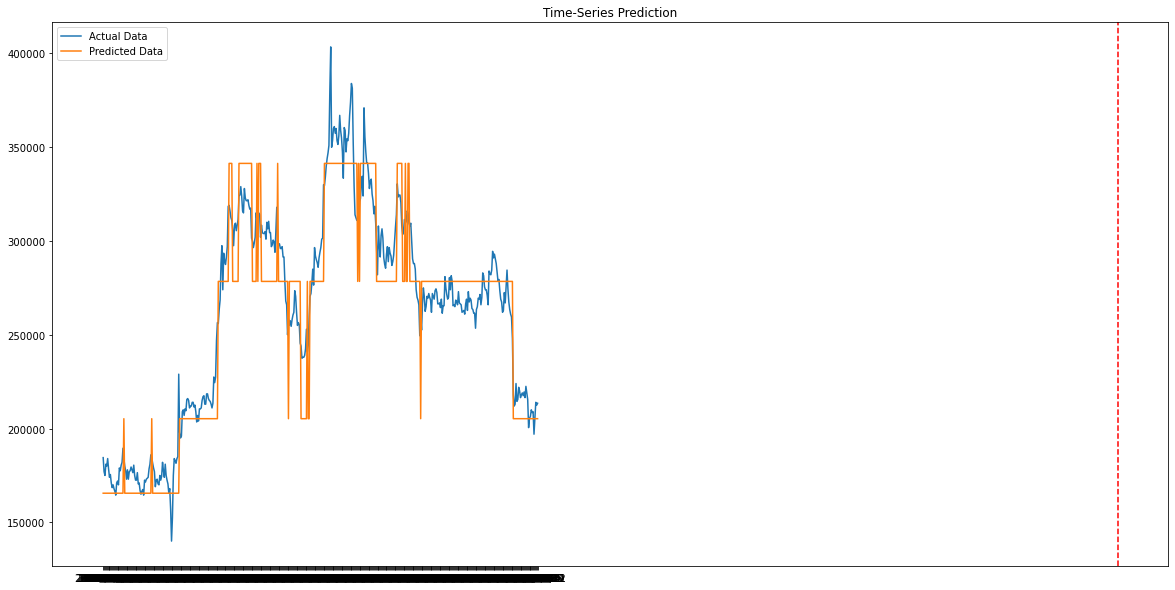

In [3]:
stocks

plt.figure(figsize=(20,10)) #plotting
plt.axvline(x= len(X_train), c='r', linestyle='--')
plt.plot(stocks['Real'], label='Actual Data') #actual plot
plt.plot(stocks['Predicted'], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 45, 15)            1020      
_________________________________________________________________
dropout (Dropout)            (None, 45, 15)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 45, 15)            1860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 15)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

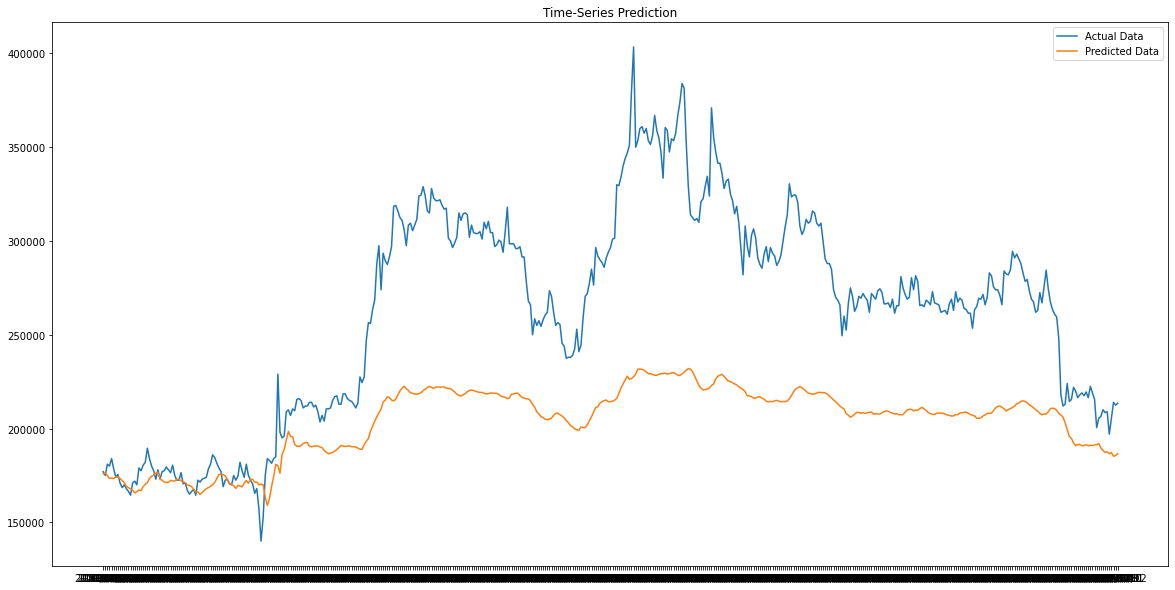

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

company_data = pd.read_csv('./data/result/셀트리온_test_1_result.csv', encoding="cp949")
company_data.dropna(inplace = True)

p_company_data = company_data[['일자', '종가','sumPos', 'sumNeg', '대비', '등락률', '시가', '고가', '저가', '거래량']]
p_company_data = p_company_data.rename(columns = {"일자":"date","종가":"close", "대비":"vs", "등락률":"ratio", "시가":"current_price", "고가":"high_price", 
                                                  "저가":"low_price", "거래량":"trade_volume"})
p_company_data = p_company_data.set_index('date')
p_company_data['Pct_change'] = p_company_data['close'].pct_change()
p_company_data.dropna(inplace = True)

# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, 
                feature_col_number4,feature_col_number5,feature_col_number6,feature_col_number7,feature_col_number8,
                feature_col_number9, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_sumPos = []
    X_sumNeg = []
    X_vs=[]
    X_ratio =[]
    X_current_price=[]
    X_high_price = []
    X_low_price = []
    X_trade_volume = []
    
    
    
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_sumPos, ts_sumNeg, and target in the loop
        ts_close = df.iloc[i:(i + window), feature_col_number1]
        ts_sumPos = df.iloc[i:(i + window), feature_col_number2]
        ts_sumNeg = df.iloc[i:(i + window), feature_col_number3]
        
        ts_vs = df.iloc[i:(i + window), feature_col_number4]
        ts_ratio = df.iloc[i:(i + window), feature_col_number5]
        ts_current_price = df.iloc[i:(i + window), feature_col_number6]
        
        ts_high_price = df.iloc[i:(i + window), feature_col_number7]
        ts_low_price = df.iloc[i:(i + window), feature_col_number8]
        ts_trade_volume = df.iloc[i:(i + window), feature_col_number9]
        
        
        


        target = df.iloc[(i + window), target_col_number]
        # Append values in the lists
        X_close.append(ts_close)
        X_sumPos.append(ts_sumPos)
        X_sumNeg.append(ts_sumNeg)
        X_vs.append(ts_vs)
        X_ratio.append(ts_ratio) 
        X_current_price.append(ts_current_price)
        X_high_price.append(ts_high_price) 
        X_low_price.append(ts_low_price) 
        X_trade_volume.append(ts_trade_volume) 
        y.append(target)
        
    return np.hstack((X_close,X_sumPos,X_sumNeg, X_vs, X_ratio, X_current_price, X_high_price, X_low_price, X_trade_volume)), np.array(y).reshape(-1, 1)

# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 5

# Column index 0 is the `Close` column
# Column index 1 is the `sumPos` column
# Column index 2 is the `sumNeg` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
feature_col_number4 = 3
feature_col_number5 = 4
feature_col_number6 = 5
feature_col_number7 = 6
feature_col_number8 = 7
feature_col_number9 = 8





target_col_number = 0
X, y = window_data(p_company_data, window_size, feature_col_number1, 
                   feature_col_number2, feature_col_number3,feature_col_number4, feature_col_number5, 
                   feature_col_number6, feature_col_number7, feature_col_number8, feature_col_number9, 
                   target_col_number)

# Use 70% of the data for training and the remainder for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

# Scaling Data with MinMaxScaler
# value 0 ~ 1
# scale both features and target sets

# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X)
y_train_scaler.fit(y)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

'''
# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)
'''


# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

number_units = 15
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
    
model.add(Dropout(dropout_fraction))

# Layer 2
# The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer.
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", metrics = ['accuracy'], loss="mean_squared_error")

# Summarize the model
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=5, verbose=1)

# Evaluate the model for loss
model.evaluate(X_test, y_test)

# Make some predictions
predicted = model.predict(X_test)

# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

# Recover the original prices instead of the scaled version
predicted_prices = y_train_scaler.inverse_transform(predicted)
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = p_company_data.index[-len(real_prices): ]) 

print(stocks)

plt.figure(figsize=(20,10)) #plotting

plt.plot(stocks['Real'], label='Actual Data') #actual plot
plt.plot(stocks['Predicted'], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [5]:
y_pred = predicted
y_pred_price = y_train_scaler.inverse_transform(y_pred)
y_test_price = y_train_scaler.inverse_transform(y_test)
print(y_pred_price)

[[175829.31]
 [176288.92]
 [174967.52]
 [173415.06]
 [173651.39]
 [173290.19]
 [174124.66]
 [174172.52]
 [173367.06]
 [172322.98]
 [171179.78]
 [169229.11]
 [168526.7 ]
 [167813.5 ]
 [167013.47]
 [165631.31]
 [166374.69]
 [167274.6 ]
 [166879.16]
 [169095.36]
 [170208.67]
 [171229.2 ]
 [173414.19]
 [174595.05]
 [175317.12]
 [176227.73]
 [176553.17]
 [173282.69]
 [172402.19]
 [171514.17]
 [171254.4 ]
 [171283.98]
 [172339.83]
 [172082.78]
 [172006.64]
 [173017.56]
 [172761.27]
 [172223.03]
 [171479.02]
 [171167.53]
 [169873.27]
 [169628.22]
 [169076.64]
 [167625.67]
 [166169.45]
 [166288.3 ]
 [164851.02]
 [165913.25]
 [166953.17]
 [167950.06]
 [168510.69]
 [169216.98]
 [170072.52]
 [171353.2 ]
 [173365.12]
 [175559.5 ]
 [175509.  ]
 [175418.84]
 [174849.19]
 [172424.38]
 [170832.34]
 [170374.66]
 [169484.8 ]
 [168082.22]
 [169669.98]
 [169361.3 ]
 [168884.36]
 [170866.94]
 [172313.55]
 [170908.44]
 [172915.86]
 [173016.33]
 [171399.48]
 [171454.45]
 [169932.94]
 [170340.83]
 [170160.22]

In [6]:
print(len(y_pred_price))
print(len(y_test_price))

483
483


In [7]:
l =[]
for i in range(len(y_test_price)-1):
    if y_test_price[i] - y_pred_price[i+1] >= 0:
        l.append(0)
    else:
        l.append(1)

print(l)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
s =[]
for i in range(len(y_test_price)-1):
    if y_test_price[i] - y_test_price[i+1] >=0:
        s.append(0)
    else:
        s.append(1)
        
print(s)

[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 

In [9]:
t = []
for i in range(len(l)):
    if l[i] == s[i] :
        t.append(1)
        
    else:
        t.append(0)

print(t)

[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 

In [10]:
from collections import Counter

Counter(t)

Counter({1: 267, 0: 215})

In [11]:
a = Counter(t)

In [12]:
a[1] / (a[0]+a[1])

0.553941908713693